In [39]:
## 1. Test the effect of different weight functions on network inversion
## 2. Test the effect of different min-criteria on network inversion

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pysar.simulation as psim
from pysar.simulation.plot import *
from pysar.utils import ptime, readfile, writefile, utils as ut, network as pnet, plot as pp
from pysar.objects import timeseries, ifgramStack, sensor
import pysar.ifgram_inversion as ifginv


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_rms_weightFunc'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)

ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'
sensorName = sensor.project_name2sensor_name(ref_dir)[0]

# read info for time-series
ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
tbase_diff = np.diff(np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25).reshape(-1, 1)
dates, datevector = ptime.date_list2vector(date_list)
tbase = np.array(ts_obj.tbase)
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

# read info for network setup
ref_ifg_file = os.path.join(ref_dir, 'INPUTS/ifgramStack.h5')
stack_obj = ifgramStack(ref_ifg_file)
stack_obj.open()
date12_list = stack_obj.get_date12_list()
#date12_list = ptime.yyyymmdd_date12(pnet.select_pairs_all(date_list))
A, B = stack_obj.get_design_matrix4timeseries_estimation(date12_list=date12_list)
print('number of ifgrams: {}'.format(len(date12_list)))

ts_sim = psim.sim_variable_timeseries(tbase, display=False)
print('Done.')

## settings
coh_resid = 0.1
decor_time = 50.
num_sample = 10000
L = 3 * 4**2
#L = 1
weight_func_list = ['Uniform', 'Coherence', 'Variance inv', 'Fisher info']
min_norm_velocity = True
out_file = 'netInvRms_weightFunc'
if min_norm_velocity:
    out_file += '_minVel'
else:
    out_file += '_minPha'
print('output file base: '+out_file)

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_rms_weightFunc
open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
open ifgramStack file: ifgramStack.h5
number of ifgrams: 490
Done.
output file base: netInvRms_weightFunc_minVel


In [40]:
## simulate coherence, ifgram phase with decorrelation noise and estimate coherence
def get_network_inversion_rms(ifgram, coh_data, L, min_norm_velocity=True, print_msg=True):
    """Get inversion RMS from truth for different weight functions"""
    num = len(weight_func_list)
    rms = np.zeros(num, np.float32)
    for i in range(num):
        weight_func = weight_func_list[i]
        weight = ifginv.coherence2weight(coh_data, weight_func=weight_func, L=L, print_msg=False)
        if weight is not None:
            weight = np.sqrt(weight)
        ts_inv = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram, weight_sqrt=weight,
                                            min_norm_velocity=min_norm_velocity)[0]
        ts_diff = ts_inv - np.tile(ts_sim.reshape(-1,1), (1, num_sample)) / phase2range
        rms[i] = np.sqrt(np.mean(ts_diff**2))
        if print_msg:
            print('Weight function {} with RMS: {} radian'.format(weight_func, rms[i]))
    return rms, ts_inv

def get_rms_inv(min_norm_velocity, L_step=1, L_max=20):
    #xx = np.arange(d_step, d_max+d_step, step=d_step, dtype=np.int16).reshape(-1, 1)
    xx = np.arange(L_step, L_max+L_step, step=L_step, dtype=np.int16).reshape(-1, 1)
    rms_inv = np.zeros((xx.size, len(weight_func_list)), np.float32)
    for i in range(xx.size):
        ifgram, coh_est = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                L=int(xx[i]), num_sample=num_sample,
                                                baseline_file='bl_list.txt',
                                                sensor_name=sensorName,
                                                inc_angle=inc_angle)[0:2]
        rms_inv[i, :] = get_network_inversion_rms(ifgram,
                                                  coh_est,
                                                  L=int(xx[i]),
                                                  min_norm_velocity=min_norm_velocity,
                                                  print_msg=False)[0]
        sys.stdout.write('\r{}/{}'.format(i+1, xx.size))
        sys.stdout.flush()
    print('')
    #txt_data = np.hstack((xx.reshape(-1, 1), rms_inv))
    #if min_norm_velocity:
    #    out_file = 'network_inv_rms_minNormVelcity.txt'
    #else:
    #    out_file = 'network_inv_rms_minNormPhase.txt'
    #np.savetxt(out_file, txt_data, fmt='%s', delimiter='\t')
    return xx, rms_inv
print('Done.')

Done.


In [41]:
## calculate RMS of network inversion
xx, rms_inv = get_rms_inv(min_norm_velocity=min_norm_velocity, L_max=50)
np.save(out_file, np.hstack((xx, rms_inv)))

50/50


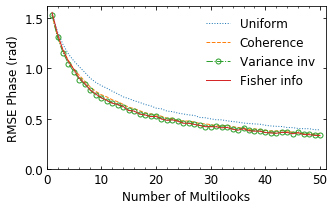

In [43]:
fcontent = np.load('{}.npy'.format(out_file))
xx = fcontent[:, 0].reshape(-1, 1)
rms_inv = fcontent[:, 1:]

marker_list = [':', '--', '-.o', '-']
ymax_list = [3.0, 1.8, 1.5, 1.3, 1.1]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 3])

for i in range(len(weight_func_list)):
    ax.plot(xx.reshape(-1, 1), rms_inv[:, i], marker_list[i], lw=1,
            ms=5, mfc='none', label=weight_func_list[i])
ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim((0, np.max(xx)+1))
ax.set_ylim(bottom=0.)
ax.set_xlabel('Number of Multilooks', fontsize=font_size)
ax.set_ylabel('RMSE Phase (rad)', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False)
ax.tick_params(which='both', direction='in', labelsize=font_size,
               bottom=True, top=True, left=True, right=True)

plt.savefig('{}.jpg'.format(out_file), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [ ]:
## subplot - normalized weighting functions changing through coherence
## calculate coherence and weight
#c0 = np.linspace(0., 1.0, 50)
#weight_norm = np.zeros((c0.size, len(weight_func_list)), np.float32)
#for i in range(len(weight_func_list)):
#    w0 = ifginv.coherence2weight(c0, weight_func=weight_func_list[i], L=L)
#    if w0 is None:
#        w0 = np.ones((c0.size), np.float32)
#    w0 /= np.max(w0)
#    weight_norm[:, i] = w0
#print('Done.')

#for i in range(len(weight_func_list)):
#    ax1.plot(c0, weight_norm[:, i], marker_list[i], lw=2,
#             ms=5, mfc='none', label=weight_func_list[i])
#ax1.set_yscale('log')
#ax1.set_xlabel('Coherence', fontsize=font_size)
#ax1.set_ylabel('Normalized Weight', fontSize=font_size)
#ax1.set_xlim([0., 1.])


#ax1.annotate('(a)', xy=(0.88, 0.05), fontsize=font_size, xycoords='axes fraction')
#ax.annotate('(b)', xy=(0.88, 0.05), fontsize=font_size, xycoords='axes fraction')
#fig.subplots_adjust(wspace=0.3)

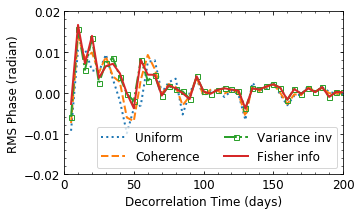

In [43]:
fig, ax = plt.subplots(figsize=[5, 3])
for i in range(len(weight_func_list)):
    ax.plot(decor_time.reshape(-1, 1), rms_inv_minVel[:, i] - rms_inv_minPha[:, i], marker_list[i], lw=2,
            ms=5, mfc='none', label=weight_func_list[i])
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlim((0, 200))
ax.set_ylim((-0.02, 0.02))
plt.xlabel('Decorrelation Time (days)', fontsize=font_size)
plt.ylabel('RMS Phase (radian)', fontsize=font_size)
plt.legend(fontsize=font_size, ncol=2)
plt.savefig('netInv_rms_minVel-minPha.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

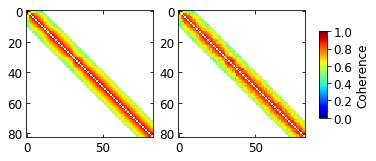

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[5, 3])
for ax, data in zip(axs, [coh_sim, coh_est]):
    data_mat = pnet.coherence_matrix(date12_list, data)
    im = ax.imshow(data_mat, vmin=0, vmax=1., cmap='jet')
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.94, 0.3, 0.02, 0.4])
cbar = plt.colorbar(im, cax)
cbar.set_label('Coherence', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.savefig('')
plt.show()

In [54]:
cbar.ax

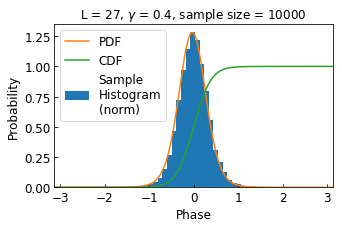

In [25]:
x = psim.sample_decorrelation_phase(L, 0.4, size=int(1e4), display=True)

In [14]:
np.arange(10, 1000, step=10).size

99

In [16]:
filec = np.load('{}.npy'.format(out_file))
filec[:, 0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.],
      dtype=float32)